# Test the results differences within continents
1. Regenerate the clusters within each continent
2. Compare the clustered results
3. Reconstruct regression models

In [30]:
import os
import pandas as pd
import numpy as np
import h3
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial import distance
import os
from shapely.geometry import Polygon
import geopandas as gpd
ROOT_DIR = "../../"
import sys
sys.path.append(ROOT_DIR)
from utils.citymeta import load_all
from utils.cluster import ClusterAttr

"""This time only looks at within city data."""
plt.rcParams["figure.figsize"] = [3, 4]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['svg.fonttype'] = 'none'

In [36]:
# load tsne data

ROOTFOLDER = "D:/Dropbox (Personal)/Personal Work/_Projects2023/01_city-never-was"
# ROOTFOLDER = "/Users/yuan/Dropbox (Personal)/Personal Work/_Projects2023/01_city-never-was"
DATA_FOLDER = f"{ROOTFOLDER}/_data/_curated/c_seg_hex"
DATA_EXPORT = f"{ROOTFOLDER}/_data/_curated/c_hex_cluster"
SEG_FOLDER = f"{ROOTFOLDER}/_data/_curated/c_analysis"
if not os.path.exists(DATA_EXPORT):
    os.makedirs(DATA_EXPORT)
BOUND_FOLDER = f"{ROOTFOLDER}/_data/_raw/r_boundary_osm"

# GRAPHIC_PATH = "/group/geog_pyloo/08_GSV/_graphic/cluster/allcities"
GRAPHIC_PATH = f"{ROOTFOLDER}/_graphic/cluster_figure"
if not os.path.exists(GRAPHIC_PATH):
    os.makedirs(GRAPHIC_PATH)
res = 9
N_CAT = 27
PREFIXFULL = "_built_environment"

variables_sel_top1_order = ClusterAttr.variables_sel_top1_order
variables_sel_top1_order_all = ClusterAttr.variables_sel_top1_order_all
len(variables_sel_top1_order)
variables_sel_order = ClusterAttr.variables_sel_order

FILENAME_WITHIN = "c_seg_cat={N_CAT}_res={res}_withincity{prefixfull}_tsne.parquet"
FILENAME_ORI_WITHIN = "c_seg_cat={N_CAT}_res={res}_withincity.parquet"
# load continent
city_meta = load_all("select_city_classifier")
region_ls = city_meta[['city_lower','Continent']].drop_duplicates().reset_index(drop = True)

In [37]:
variables_sel_top1_order = ClusterAttr.variables_sel_top1_order
variables_sel_top1_order_all = ClusterAttr.variables_sel_top1_order_all
len(variables_sel_top1_order)
variables_sel_order = ClusterAttr.variables_sel_order
variables_sel_order

{'_built_environment': ['skyscraper',
  'light',
  'road',
  'sidewalk',
  'traffic light',
  'window',
  'building',
  'signage',
  'pole',
  'trashcan',
  'installation',
  'railing',
  'shrub',
  'grass',
  'tree',
  'lake+waterboday',
  'sky',
  'sportsfield',
  'mountain+hill'],
 '': ['skyscraper',
  'car',
  'van',
  'light',
  'road',
  'sidewalk',
  'traffic light',
  'bus',
  'window',
  'building',
  'signage',
  'pole',
  'truck',
  'bike',
  'person',
  'trashcan',
  'installation',
  'railing',
  'shrub',
  'grass',
  'tree',
  'lake+waterboday',
  'sky',
  'sportsfield',
  'mountain+hill']}

In [44]:
def plot_wss_kmean(data, N, comment):
    """Try Kmean instead"""
    
    wss = []
    distorsions = []
    silhouette = []
    
    for i in range(2,N):
        print("cluster: ", i)
        km = KMeans(n_clusters=i, random_state=0)
        km.fit(data)
        wss.append(km.inertia_)
        distorsions.append(sum(np.min(distance.cdist(data,
        km.cluster_centers_, 'euclidean'),axis=1)) /
        data.shape[0])
        
        
    sns.set(style="whitegrid")
    sns.set_context("paper", rc={"font.size":10,"axes.titlesize":12,"axes.labelsize":12})

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    ax1, ax2 = axes
    ax1.plot(range(2,N), wss, 'bx-', color='black')
    # make sure the x-axis is in integers
    ax1.set_xticks(np.arange(2, N, step=1))
    ax1.set_xlabel('Number of clusters $K$')
    ax1.set_ylabel('Inertia')
    ax1.set_title('The Elbow Method showing the optimal $K$')
    
    ax2.plot(range(2,N), distorsions, 'bx-', color='black')
    # make sure the x-axis is in integers
    ax2.set_xticks(np.arange(2, N, step=1))
    ax2.set_xlabel('Number of clusters $K$')
    ax2.set_ylabel('Distorsion')
    ax2.set_title('The Elbow Method showing the optimal $K$')
    fig.savefig(os.path.join(GRAPHIC_PATH,f"elbow_silhouette_volume_{N}_{comment}.png"), dpi=200, bbox_inches = 'tight')
    plt.show()
    
    return wss, distorsions


def cell_to_shapely(cell):
    coords = h3.h3_to_geo_boundary(cell)
    flipped = tuple(coord[::-1] for coord in coords)
    return Polygon(flipped)

def load_df(prefixfull):
    df_seg_summary = pd.read_csv(os.path.join(SEG_FOLDER, 'c_exposure_sidewalk_h3.csv'))
    df_within = pd.read_parquet(os.path.join(DATA_FOLDER, FILENAME_WITHIN.format(res = res, prefixfull = prefixfull, N_CAT = N_CAT)))
    
    df_within = df_within.merge(region_ls, on = 'city_lower', how = 'left').drop_duplicates()
    df_ori_within = pd.read_parquet(os.path.join(DATA_FOLDER, 
                                                 FILENAME_ORI_WITHIN.format(res = res, 
                                                                            N_CAT = N_CAT, 
                                                                            prefixfull = prefixfull)))
    df_ori_within = df_ori_within.merge(region_ls, on = 'city_lower', how = 'left').drop_duplicates()
    
    print("original size:", df_within.shape[0])
    # filter out hex with too few images (fewer than 10 images)
    df_within = df_within[df_within['img_count']>4].reset_index(drop = True)
    print("after dropping size:",df_within.shape[0])

    df_with_exposure = df_seg_summary[df_seg_summary['exposure_indicator']>0].reset_index(drop = True)
    df_with_exposure_within = df_within[df_within['hex_id'].isin(df_with_exposure['h3_9'].unique())].reset_index(drop =True)
    print("after dropping size:",df_with_exposure_within.shape[0])
    return df_with_exposure_within, df_ori_within


def generate_cluster(df_with_exposure_within, df_ori_within, prefixfull, region_ls, continent = None):
    
    if continent is not None:
        df_temp = df_with_exposure_within[df_with_exposure_within['Continent'] == continent].reset_index(drop = True)
    else:
        df_temp = df_with_exposure_within.copy()
    data = df_temp[['tsne_1', 'tsne_2']].copy()
    wss, distorsions = plot_wss_kmean(data, 21, f"tsne-2d_{prefixfull}")
    # print(wss, distorsions, silhouettes)

    cluster_ls = [5,7]
    for n in cluster_ls:
        km = KMeans(n_clusters=n, random_state=0)
        km.fit(data)
        df_temp[f'cluster_{n}'] = km.labels_

    df_ori_within = df_ori_within.merge(df_temp[['city_lower','hex_id','res']+[f'cluster_{n}' for n in cluster_ls]], 
                                on = ['city_lower','hex_id', 'res'],
                                how = 'inner'
                                ).drop_duplicates()
    continentlower = continent.lower().replace(" ", "") if continent is not None else 'all'
    df_ori_within.to_csv(os.path.join(DATA_FOLDER, 
                                f"c_seg_cat={N_CAT}_res={res}_continent={continentlower}_withincity{prefixfull}_tsne_cluster_range.csv"), index=False)
    return df_ori_within

# summarize the cluster type
def summarize_cluster(df_ori_within, n, prefix):
    variable_order = variables_sel_order[prefix]
    df_summary = df_ori_within[variable_order+[f"cluster_{n}"]].groupby(f"cluster_{n}").mean().stack().reset_index()\
    .rename(columns = {"level_1":"category", 0:"std_value"})


    df_summary_update = []
    for v in df_summary["category"].unique():
        temp = df_summary[df_summary["category"]==v].reset_index(drop = True)
        temp["norm_value"] = (temp["std_value"] - temp["std_value"].min())/(temp["std_value"].max() - temp["std_value"].min())
        df_summary_update.append(temp)
        
    df_summary_update = pd.concat(df_summary_update).reset_index()

    df_heat = df_summary_update.pivot(
        columns= "category", values = "norm_value", index = f"cluster_{n}"
    )[variable_order].sort_values(variable_order[:5], ascending = False)
    return df_heat
   
def plot_summary(df_ori_within, n, prefixfull, continent = None):
    if prefixfull=="":
        figsize = (14, 4.5)
    else:
        figsize = (11, 4.5)
    fig, ax = plt.subplots(figsize = figsize)
    # use a gradient color
    # cluster_order = [3,2,5,6,0,4,1,7]
    df_heat = summarize_cluster(df_ori_within, n, prefixfull)
    cmap = sns.color_palette("blend:#88572C,#ddb27c,#b5f2f5,#12939a", as_cmap=True)
    sns.heatmap(df_heat.sort_values(['skyscraper','building']), 
                cmap = cmap, annot = True, fmt=".2f", 
                ax = ax)
    # show axis annotation larger
    ax.tick_params(axis='both', which='major', labelsize=12)
    # show ticks to the left
    ax.yaxis.tick_left()
    plt.yticks(rotation=0)
    # show ticks to the bottom
    ax.xaxis.tick_top()
    # rotate the x axis
    plt.xticks(rotation=45)
    plt.tight_layout()
    # save figure to svg
    continentlower = continent.lower().replace(" ", "") if continent is not None else 'all'
    plt.savefig(
        os.path.join(GRAPHIC_PATH, f"cluster_svf_attributes_{n}{prefixfull}{continentlower}.svg"),
        dpi = 200,
                ) 

In [48]:
prefixfull = PREFIXFULL
df_with_exposure_within, df_ori_within = load_df(prefixfull)

original size: 406928
after dropping size: 390281
after dropping size: 388217


cluster:  2
cluster:  3
cluster:  4
cluster:  5
cluster:  6
cluster:  7
cluster:  8
cluster:  9
cluster:  10
cluster:  11
cluster:  12
cluster:  13
cluster:  14
cluster:  15
cluster:  16
cluster:  17
cluster:  18
cluster:  19
cluster:  20


C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_32112\4039532001.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(range(2,N), wss, 'bx-', color='black')
C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_32112\4039532001.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(range(2,N), distorsions, 'bx-', color='black')


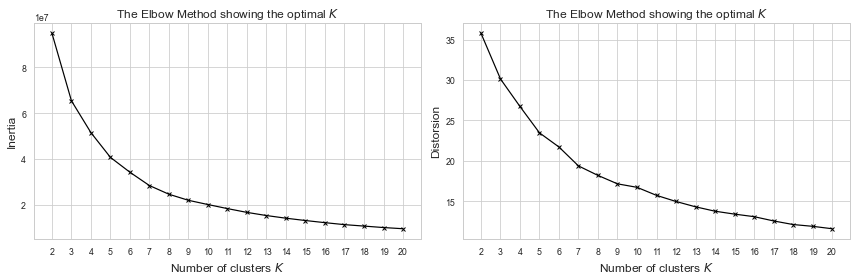

cluster:  2
cluster:  3
cluster:  4
cluster:  5
cluster:  6
cluster:  7
cluster:  8
cluster:  9
cluster:  10
cluster:  11
cluster:  12
cluster:  13
cluster:  14
cluster:  15
cluster:  16
cluster:  17
cluster:  18
cluster:  19
cluster:  20


C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_32112\4039532001.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(range(2,N), wss, 'bx-', color='black')
C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_32112\4039532001.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(range(2,N), distorsions, 'bx-', color='black')


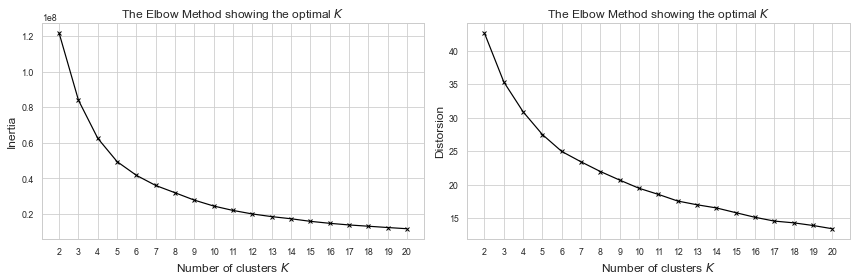

cluster:  2
cluster:  3
cluster:  4
cluster:  5
cluster:  6
cluster:  7
cluster:  8
cluster:  9
cluster:  10
cluster:  11
cluster:  12
cluster:  13
cluster:  14
cluster:  15
cluster:  16
cluster:  17
cluster:  18
cluster:  19
cluster:  20


C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_32112\4039532001.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(range(2,N), wss, 'bx-', color='black')
C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_32112\4039532001.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(range(2,N), distorsions, 'bx-', color='black')


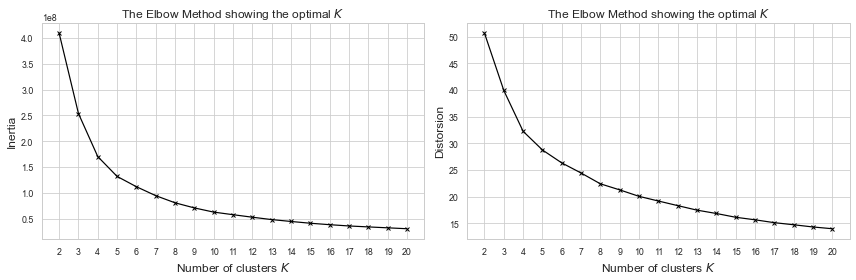

cluster:  2
cluster:  3
cluster:  4
cluster:  5
cluster:  6
cluster:  7
cluster:  8
cluster:  9
cluster:  10
cluster:  11
cluster:  12
cluster:  13
cluster:  14
cluster:  15
cluster:  16
cluster:  17
cluster:  18
cluster:  19
cluster:  20


C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_32112\4039532001.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(range(2,N), wss, 'bx-', color='black')
C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_32112\4039532001.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(range(2,N), distorsions, 'bx-', color='black')


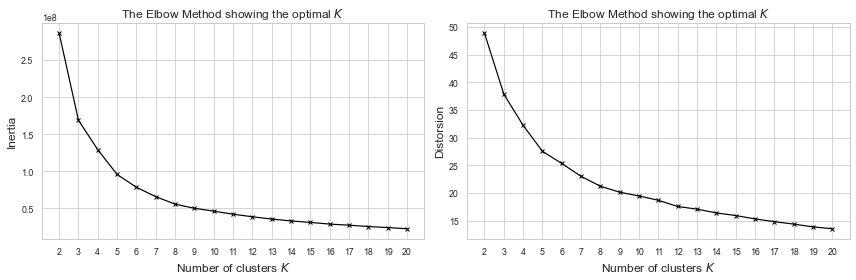

In [49]:

for continent in ['North America', 'South America', 'Asia', 'Europe']:
    generate_cluster(df_with_exposure_within, df_ori_within, prefixfull, region_ls, continent = continent)

In [50]:
# use the husl color to map to each cluster
import seaborn as sns
def get_color_palette(n):
    color_palette = sns.color_palette("husl", n)
    color_dict = dict(zip(range(n), color_palette))
    return color_palette, color_dict

plotting North America done
plotting South America done
plotting Asia done
plotting Europe done


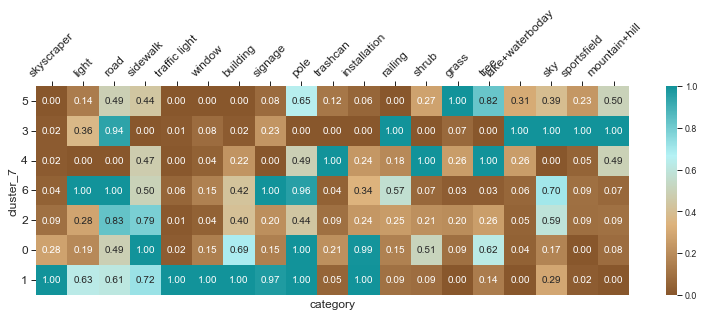

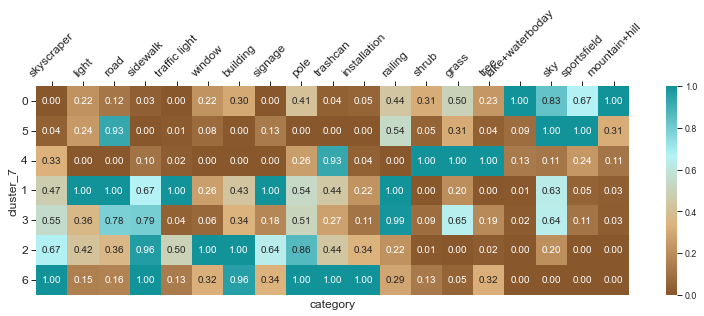

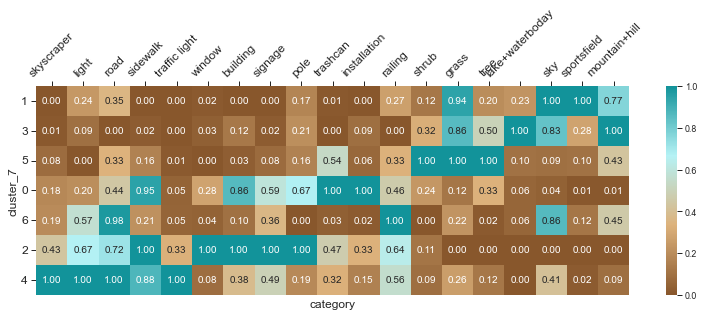

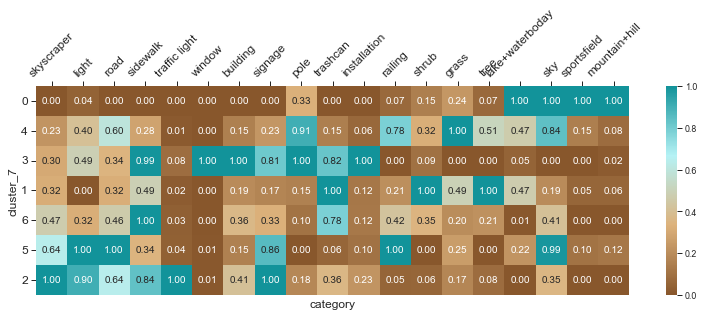

In [51]:
n = 7
prefixfull = PREFIXFULL
# plot the summary for all continents
for continent in ['North America', 'South America', 'Asia', 'Europe']:
    continentlower = continent.lower().replace(" ", "")
    
    df_ori_within = pd.read_csv(os.path.join(DATA_FOLDER,
                                    f"c_seg_cat={N_CAT}_res={res}_continent={continentlower}_withincity{prefixfull}_tsne_cluster_range.csv"))
    plot_summary(df_ori_within, n, prefixfull, continent = continent)
    print(f"plotting {continent} done")